# Solving a Partial Differential Equation (PDEs) using a Physics-Informed Neural Network (PINN)
Let's solve the following ODE as an example:

$$-\frac{d^2u}{dx^2} - \frac{d^2u}{dy^2}= f(x), \quad (x,y) \in \Omega = (0,1)^2$$​
$$u = 0 \quad \text{on}\ \partial \Omega$$

This is an exponential decay problem, whose solution is
$$u = \sin(\pi x)\sin(\pi y)$$
$$f = \pi^2 \sin(\pi x)\sin(\pi y)$$


**Step 1: Define the Neural Network**

Create a neural network that takes temporal coordinates as inputs and outputs the solution to the PDE at those points. Ensure that the network has enough capacity (layers and neurons) to capture the complexity of the solution.

In [2]:
import torch
import torch.nn as nn

torch.set_default_dtype(torch.float64)

class PDE_Net(nn.Module):
    def __init__(self):
        super(PDE_Net, self).__init__()
        hidden_features = 50
        in_features = 2
        out_features = 1
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, out_features)
        self.act = nn.Tanh()
        # Initialize weights and biases
        self.initialize_weights()

    def initialize_weights(self):
        # Example initialization: He initialization for weights and zeros for biases
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='tanh')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.fc3(x)


**Step 2: Define the Loss Function for the PDE**

The loss function should include the PDE's residual (the difference between the left-hand side and right-hand side of the PDE).

In [3]:
def eval_loss_pde(u_pred, input, f):

    x = input[:, :-1]
    t = input[:, -1]
    u_pred.requires_grad_(True)

    grad_u_pred = torch.autograd.grad(u_pred, input, grad_outputs=torch.ones_like(u_pred), retain_graph=True, create_graph=True, only_inputs=True)[0]
    grad_u_pred_t = grad_u_pred[:, -1].unsqueeze(1)

    grad2_u_pred_xx = torch.autograd.grad(grad_u_pred[:, 0].unsqueeze(1), input, grad_outputs=torch.ones_like(u_pred), retain_graph=True, create_graph=True, only_inputs=True)[0][:, 0].unsqueeze(1)
    grad2_u_pred_yy = torch.autograd.grad(grad_u_pred[:, 1].unsqueeze(1), input, grad_outputs=torch.ones_like(u_pred), retain_graph=True, create_graph=True, only_inputs=True)[0][:, 1].unsqueeze(1)

    f = rhs_f(u_pred)

    # PDE residual
    loss_pde = ((grad_u_pred_t - grad2_u_pred_xx - grad2_u_pred_yy - f).pow(2)).mean()

    return loss_pde

# def compute_pde_residual(u_pred, x, f):
#     grad_u_pred = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred),
#             retain_graph=True, create_graph=True, only_inputs=True)[0]

#     grad2_u_pred_xx = torch.autograd.grad(grad_u_pred[:, 0].unsqueeze(1), x, grad_outputs=torch.ones_like(u_pred),
#             retain_graph=True, create_graph=True, only_inputs=True)[0][:, 0]
#     grad2_u_pred_yy = torch.autograd.grad(grad_u_pred[:, 1].unsqueeze(1), x, grad_outputs=torch.ones_like(u_pred),
#             retain_graph=True, create_graph=True, only_inputs=True)[0][:, 1]

#     f = rhs_f(x)

#     # PDE residual
#     residual = (-grad2_u_pred_xx - grad2_u_pred_yy - f)

#     return residual

**Step 3: Define the Loss Function for enforcing Dirichlet boundary conditions**

The loss function should include the Dirichlet boundary condition.

In [ ]:
def eval_loss_bc(u_pred, input):

    x = input[:, :-1]
    u_pred.requires_grad_(True)
    grad_u_pred = torch.autograd.grad(u_pred, input, grad_outputs=torch.ones_like(u_pred), retain_graph=True, create_graph=True, only_inputs=True)[0]
    loss_bc = grad_u_pred.pow(2).mean()

    return loss_bc

# def eval_loss_bc(u_pred_1, u_pred_2, u_pred_3, u_pred_4, u_bc_1, u_bc_2,u_bc_3, u_bc_4):
#     # Enforce the initial condition
#     loss_bc = (u_pred_1 - u_bc_1).pow(2).mean() + (u_pred_2 - u_bc_2).pow(2).mean() + (u_pred_3 - u_bc_3).pow(2).mean() + + (u_pred_4 - u_bc_4).pow(2).mean()

#     return loss_bc

Create functions for analytical solution and the corresponding right hand side

In [ ]:
def rhs_f(u_pred):
  return -18.515 * u_pred * (u_pred - 0.2383) * (u_pred - 0.2383)

# def rhs_f(x):
#   pi = torch.acos(torch.zeros(1)).item() * 2  # Pi using arccos
#   return 2 * pi * pi * torch.sin(pi * x[:, 0]) * torch.sin(pi * x[:, 1])

In [ ]:
def analytical_u(x):
  pi = torch.acos(torch.zeros(1)).item() * 2  # Pi using arccos
  return (torch.sin(pi * x[:, 0]) * torch.sin(pi * x[:, 1]))


In [ ]:
def compute_relative_l2_error(u_pred, u_true):
    return torch.norm(u_pred-u_true, p=2)/torch.norm(u_true, p=2)

**Step 4: Prepare Training Data**

Generate collocation points for calculating the residuals, and points for enforcing initial conditions. These can be randomly sampled or placed on a grid.


In [ ]:
! pip install scikit-optimize
import skopt
import numpy as np

# Define the domain
num_samples = 1000
num_samples_bc = 50

space   = [(0., 1.), (0., 1.)]
sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1)
x_domain = np.array(sampler.generate(space, num_samples))

x_bc = np.linspace(0, 1, num_samples_bc)
x_bc = x_bc.reshape(num_samples_bc,1)
# x_bc = lhs(1, samples=num_samples_bc)

#space_bc = [(0., 1.)]
#x_bc = np.array(sampler.generate(space_bc, num_samples_bc))

z = np.zeros((num_samples_bc, 1))
o = np.ones((num_samples_bc, 1))

x_bc_1 = np.concatenate((x_bc, z), axis=1)
x_bc_2 = np.concatenate((o, x_bc), axis=1)
x_bc_3 = np.concatenate((x_bc, o), axis=1)
x_bc_4 = np.concatenate((z, x_bc), axis=1)

x_domain = torch.tensor(x_domain)
x_bc_1 = torch.tensor(x_bc_1)
x_bc_2 = torch.tensor(x_bc_2)
x_bc_3 = torch.tensor(x_bc_3)
x_bc_4 = torch.tensor(x_bc_4)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 893.2 kB/s eta 0:00:00


Plot the collocation points

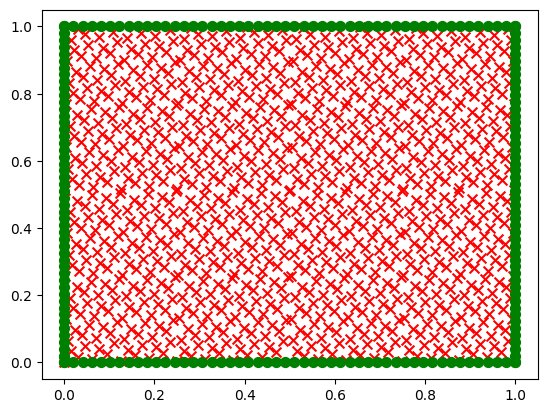

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(x_domain[:,0],x_domain[:,1], color='red', s=50, marker='x', label='Collocation Points')
plt.scatter(x_bc_1[:,0],x_bc_1[:,1], color='green', s=50, label='Collocation Points')
plt.scatter(x_bc_2[:,0],x_bc_2[:,1], color='green', s=50, label='Collocation Points')
plt.scatter(x_bc_3[:,0],x_bc_3[:,1], color='green', s=50, label='Collocation Points')
plt.scatter(x_bc_4[:,0],x_bc_4[:,1], color='green', s=50, label='Collocation Points')


Provide boundary conditions

**Step 5: Prepare Testing Data**



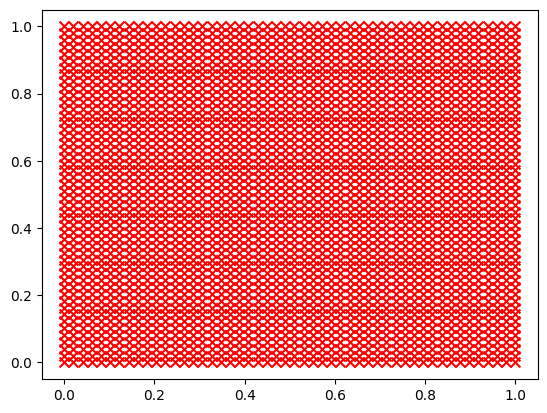

In [ ]:
xmin = 0.
ymin = 0.
xmax = 1.
ymax = 1.

X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
test_collocation = np.vstack([X.ravel(), Y.ravel()]).T
test_collocation = torch.tensor(test_collocation)

plt.scatter(test_collocation[:,0],test_collocation[:,1], color='red', s=50, marker='x', label='Collocation Points')


Consturct boundary conditions

In [ ]:
u_bc_1 = analytical_u(x_bc_1)
u_bc_2 = analytical_u(x_bc_2)
u_bc_3 = analytical_u(x_bc_3)
u_bc_4 = analytical_u(x_bc_4)

# compute the rhs
f = rhs_f(x_domain)

In [ ]:
model = PDE_Net()
#model.apply(initialize_weights)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=1e-5)

In [ ]:
num_epochs = 1000

losses = []
losses_pdes = []
losses_bcs = []

l2_train_history = []
l2_test_history = []

u_exact = analytical_u(x_domain)
u_exact_test = analytical_u(test_collocation)

# Track the best loss
best_loss = np.inf
best_model_path = 'best_model.pth'

In [ ]:
for epoch in range(num_epochs):
    x_domain.requires_grad = True

    # predict in the interior part
    u_pred = model(x_domain)
    loss_pde = eval_loss_pde(u_pred, x_domain, f)

    # boundary loss
    u_nn_bc_1 = model(x_bc_1)
    u_nn_bc_2 = model(x_bc_2)
    u_nn_bc_3 = model(x_bc_3)
    u_nn_bc_4 = model(x_bc_4)
    loss_bc = eval_loss_bc(u_nn_bc_1, u_nn_bc_2, u_nn_bc_3, u_nn_bc_4, u_bc_1, u_bc_2,u_bc_3, u_bc_4)

    # add all loss componenets
    total_loss = loss_pde + 100.*loss_bc
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())
    losses_pdes.append(loss_pde.item())
    losses_bcs.append(loss_bc.item())

    # l2_train = torch.ones(1)
    # l2_test = torch.ones(1)

    l2_train = compute_relative_l2_error(u_pred, u_exact)
    u_predtest = model(test_collocation)
    l2_test = compute_relative_l2_error(u_predtest, u_exact_test)

    l2_train_history.append(l2_train.item())
    l2_test_history.append(l2_test.item())

    if (epoch+1) % 500 == 0:
        print ('Epoch [{:5d}/{:5d}], Total Loss: {:.4e}  PDE Loss: {:.4e}  BC Loss: {:.4e}  Train error: {:.4e} Test error: {:.4e}'.format(
            epoch+1, num_epochs, total_loss.item(), loss_pde.item(), loss_bc.item(), l2_train.item(), l2_test.item()))

    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        torch.save(model.state_dict(), best_model_path)
        # print(f'Saved new best model at epoch {epoch + 1} with loss {best_loss}')

Epoch [  500/ 1000], Total Loss: 5.2376e-01  PDE Loss: 3.7726e-01  BC Loss: 1.4650e-03  Train error: 2.6195e+01 Test error: 4.3026e+01
Epoch [ 1000/ 1000], Total Loss: 1.0517e-01  PDE Loss: 8.6079e-02  BC Loss: 1.9092e-04  Train error: 2.6189e+01 Test error: 4.3009e+01


**Visualizing the Results**

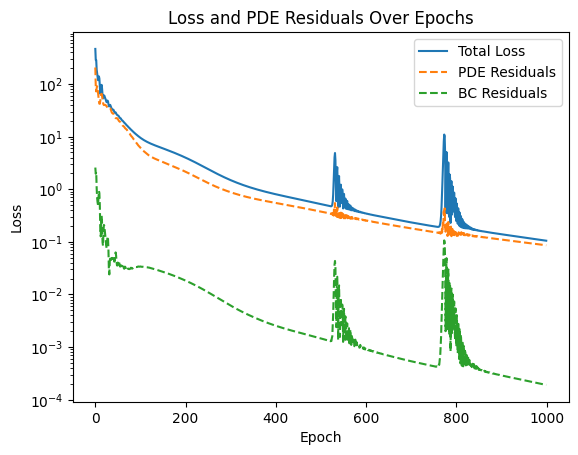

In [ ]:
plt.semilogy(losses, label='Total Loss')
plt.semilogy(losses_pdes, label='PDE Residuals', linestyle='--')
plt.semilogy(losses_bcs, label='BC Residuals', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss and PDE Residuals Over Epochs')
plt.legend()

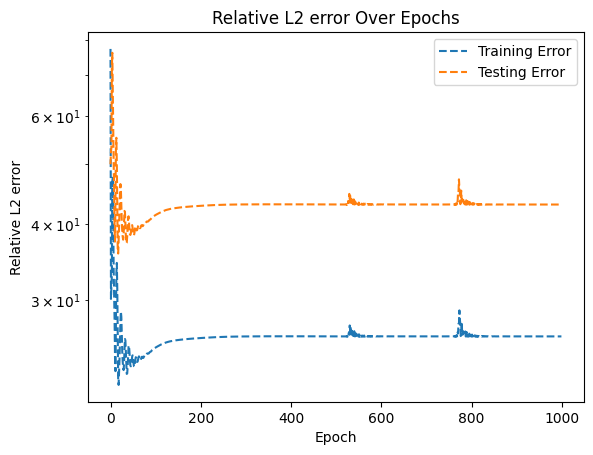

In [ ]:
plt.semilogy(l2_train_history, label='Training Error', linestyle='--')
plt.semilogy(l2_test_history, label='Testing Error', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Relative L2 error')
plt.title('Relative L2 error Over Epochs')
plt.legend()

Compute error

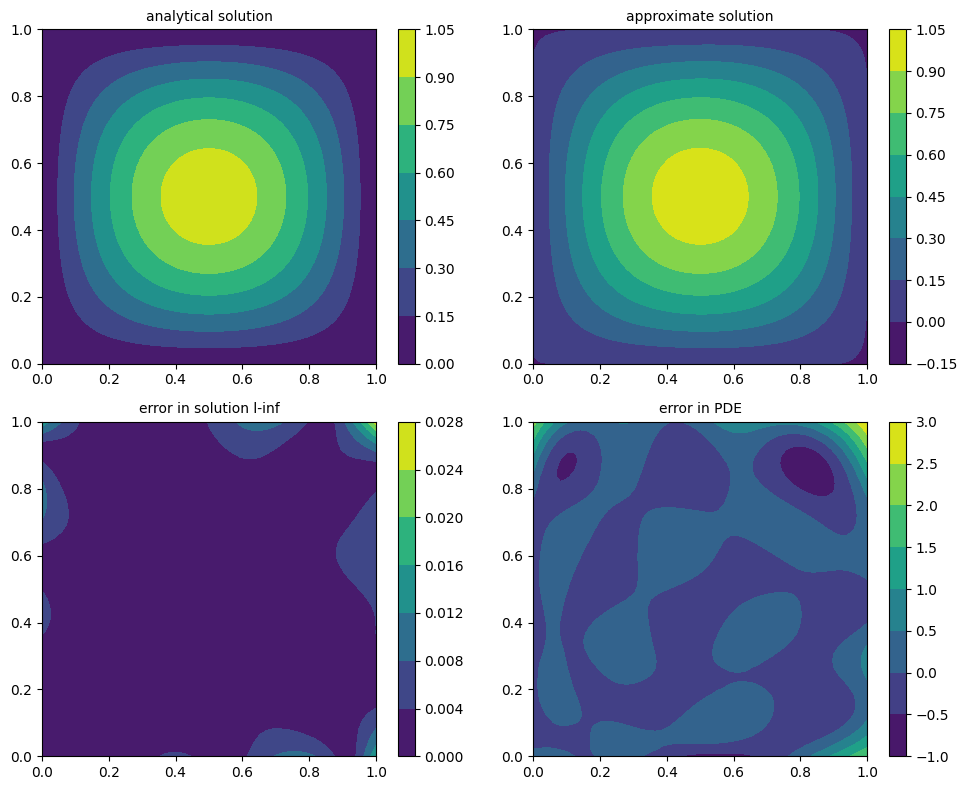

In [ ]:
test_collocation.requires_grad = True

model.load_state_dict(torch.load(best_model_path))

u_nn_domain = model(test_collocation)
f_test = rhs_f(test_collocation)


pde_error = compute_pde_residual(u_nn_domain, test_collocation, f_test)
pde_error = pde_error.data.numpy()
pde_error = pde_error.reshape(X.shape)

u_analytical = analytical_u(test_collocation)
u_analytical = u_analytical.reshape(X.shape)
u_analytical = u_analytical.data.numpy()

u_nn_domain = u_nn_domain.data.numpy()
u_nn_domain = u_nn_domain.reshape(X.shape)


fig, axs = plt.subplots(2, 2, figsize=(10, 8))
ax = axs[0, 0]
pcm = ax.contourf(X, Y, u_analytical, cmap='viridis')
ax.set_title('analytical solution', fontsize=10)
ax.set_aspect('equal', 'box')
fig.colorbar(pcm, ax=ax)


ax = axs[0, 1]
pcm = ax.contourf(X, Y, u_nn_domain, cmap='viridis')
ax.set_aspect('equal', 'box')
ax.set_title('approximate solution', fontsize=10)
fig.colorbar(pcm, ax=ax)


ax = axs[1, 0]
pcm = ax.contourf(X, Y, abs(u_nn_domain - u_analytical))
ax.set_aspect('equal', 'box')
ax.set_title('error in solution l-inf', fontsize=10)
fig.colorbar(pcm, ax=ax)

ax = axs[1, 1]
pcm = ax.contourf(X, Y, pde_error)
ax.set_aspect('equal', 'box')
ax.set_title('error in PDE', fontsize=10)
fig.colorbar(pcm, ax=ax)


fig.tight_layout()

plt.show()